# Statistical Analysis of Data

## Environment Settings

An statistical Analysis of the data captured will be performed.

The environment configuration is the following:

- A rectangle area is used whose dimension is 2 x 1.5 meters. 
- A custom robot similar to an epuck was used.
- The robot starts in the middle of the arena.
- The robot moves in a random fashion way around the environment avoiding obstacles.
- The robot has 8 sensors that measure the distance between the robot and the walls.
- Some noise was introduced in the sensors measurements of the robot using the concept of [lookup tables](https://cyberbotics.com/doc/reference/distancesensor) in the Webots simulator which according to Webots documentation "The first column of the table specifies the input distances, the second column specifies the corresponding desired response values, and the third column indicates the desired standard deviation of the noise. The noise on the return value is computed according to a gaussian random number distribution whose range is calculated as a percent of the response value (two times the standard deviation is often referred to as the signal quality)". The following values were taken:
    -Second experiment:
        - (0, 0, 0.2)
        - (10, 10, 0.2)
- The simulator runs during 10 minutes in fast mode which is translated into 12 hours of collected data.

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install keras

import pandas as pd
import tensorflow as tf
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from keras import models
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
from keras import optimizers

Using TensorFlow backend.


In [2]:
csv_file = 'robot_info_dataset-jumped.csv'
df = pd.read_csv(csv_file)
df.head()

,Unnamed: 0,x,y,theta,dx,dy,dtheta,sensor_1,sensor_2,sensor_3,...,sensor_7,sensor_8,dsensor_1,dsensor_2,dsensor_3,dsensor_4,dsensor_5,dsensor_6,dsensor_7,dsensor_8
0,0,0.920614,0.761198,168.209483,-0.070670,0.011198,-11.790739,1.085179,0.790267,0.893342,...,1.139790,1.144901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.850135,0.775909,168.212418,-0.070479,0.014711,0.002935,0.571635,0.596799,0.883340,...,0.830057,1.028332,-0.513544,-0.193468,-0.010002,-0.430864,-0.070277,-0.387726,-0.309733,-0.116568
2,2,0.779657,0.790625,168.209551,-0.070478,0.014716,-0.002867,0.581452,0.904627,0.689004,...,0.491200,0.889130,0.009817,0.307828,-0.194336,0.239518,0.206480,0.293382,-0.338857,-0.139203
3,3,0.709174,0.805340,168.212871,-0.070483,0.014715,0.003319,0.956302,0.842911,0.796714,...,1.246415,0.712158,0.374849,-0.061716,0.107710,0.075412,-0.345782,-0.084918,0.755215,-0.176971
4,4,0.638698,0.820056,168.208857,-0.070477,0.014716,-0.004013,0.671731,0.779896,0.962191,...,0.567806,0.595164,-0.284570,-0.063014,0.165477,0.005216,0.128150,-0.054777,-0.678608,-0.116994


## Data pre-processing

The data collected 1384848 samples.

In [3]:
df.shape

(65342, 23)

The data set contains some null values so they should be deleted from the samples.

In [4]:
df = df.dropna()

Now the data will be normalized.

In [5]:
normalized_df=(df-df.min())/(df.max()-df.min())
normalized_df.describe()

,Unnamed: 0,x,y,theta,dx,dy,dtheta,sensor_1,sensor_2,sensor_3,...,sensor_7,sensor_8,dsensor_1,dsensor_2,dsensor_3,dsensor_4,dsensor_5,dsensor_6,dsensor_7,dsensor_8
count,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,...,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000
mean,0.500000,0.498321,0.504753,0.502063,0.499785,0.500412,0.501624,0.239976,0.236145,0.261438,...,0.251293,0.242889,0.449485,0.468761,0.513828,0.507022,0.519272,0.531825,0.446832,0.426383
std,0.288682,0.272549,0.264025,0.290735,0.353425,0.335002,0.114192,0.140647,0.149030,0.169722,...,0.160999,0.143636,0.078247,0.073403,0.077416,0.078125,0.081846,0.080184,0.072415,0.077850
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.255777,0.269104,0.251332,0.139102,0.181098,0.496242,0.127116,0.108774,0.119219,...,0.112714,0.127502,0.412053,0.436092,0.483323,0.477268,0.488782,0.501383,0.415117,0.388997
50%,0.500000,0.498537,0.503544,0.498631,0.500020,0.500797,0.501627,0.216759,0.215659,0.237666,...,0.224880,0.220298,0.442927,0.467409,0.516314,0.512401,0.524693,0.534465,0.445713,0.419784
75%,0.750000,0.735371,0.740156,0.752400,0.860369,0.821281,0.506991,0.328127,0.337889,0.375692,...,0.360337,0.333973,0.479438,0.498031,0.547039,0.544322,0.557577,0.565527,0.475271,0.456114
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Input and output variables

The data will be split into training, testing and validation sets. 60% of the data will be used for training, 20% for training and 20% of validation.

In [6]:

# train size
test_size_percentage = .2
train_size_percentage = .8
ds_size = normalized_df.shape[0]
train_size = int(train_size_percentage * ds_size)
test_size = int(test_size_percentage * ds_size)

# shuffle dataset
normalized_df = normalized_df.sample(frac=1)

# separate inputs from outputs
inputs = normalized_df[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8']]
targets = normalized_df[['x', 'y', 'theta']]

# train
train_inputs = inputs[:train_size]
train_targets = targets[:train_size]

# test
test_inputs = inputs[train_size:(train_size + test_size)]
test_targets = targets[train_size:(train_size + test_size)]

## Neural Network


As input the neural network receives the sensor measurements as input and the target are the x, y, $\theta$ coordinates.

In [26]:

def get_model():
    # neural network with a 10-neuron hidden layer
    model = models.Sequential()
    model.add(layers.Dense(10, activation='relu', input_shape=(8,)))
    model.add(layers.Dense(3))
    
#     rmsprop = optimizers.RMSprop(learning_rate=0.01)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
              
    return model

In [27]:
def k_fold(num_epochs=10, k=5):
    num_val_samples = len(train_inputs) // k
    validation_scores = []
    histories = []
    nmse = []

    for i in range(k):
        print('processing fold #', i)
        val_data = train_inputs[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [train_inputs[:i * num_val_samples],
             train_inputs[(i + 1) * num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate(
            [train_targets[:i * num_val_samples],
             train_targets[(i + 1) * num_val_samples:]], axis=0)


        model = get_model()

        history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=1, verbose=1)
        histories.append(history.history)

        predictions_targets = model.predict(val_data)
        nmse.append(np.mean((predictions_targets - val_targets)**2)/np.var(val_targets))
        
    return histories, nmse

In [28]:
histories, nmse = k_fold(150, 5)

processing fold # 0
Train on 41818 samples, validate on 10454 samples
Epoch 1/150
41818/41818 [==============================] - 50s 1ms/step - loss: 0.0778 - mae: 0.2421 - val_loss: 0.0751 - val_mae: 0.2399
Epoch 2/150
41818/41818 [==============================] - 49s 1ms/step - loss: 0.0749 - mae: 0.2401 - val_loss: 0.0745 - val_mae: 0.2398074
Epoch 3/150
41818/41818 [==============================] - 56s 1ms/step - loss: 0.0746 - mae: 0.2401 - val_loss: 0.0740 - val_mae: 0.2395
Epoch 4/150
41818/41818 [==============================] - 43s 1ms/step - loss: 0.0744 - mae: 0.2400 - val_loss: 0.0745 - val_mae: 0.2401
Epoch 5/150
41818/41818 [==============================] - 40s 968us/step - loss: 0.0743 - mae: 0.2401 - val_loss: 0.0739 - val_mae: 0.2398
Epoch 6/150
41818/41818 [==============================] - 40s 945us/step - loss: 0.0742 - mae: 0.2399 - val_loss: 0.0738 - val_mae: 0.2397
Epoch 7/150
41818/41818 [==============================] - 39s 939us/step - loss: 0.0742 - mae:

Epoch 59/150
41818/41818 [==============================] - 40s 958us/step - loss: 0.0741 - mae: 0.2399 - val_loss: 0.0741 - val_mae: 0.2398
Epoch 60/150
41818/41818 [==============================] - 41s 974us/step - loss: 0.0741 - mae: 0.2400 - val_loss: 0.0740 - val_mae: 0.2401 loss: 0.0
Epoch 61/150
41818/41818 [==============================] - 43s 1ms/step - loss: 0.0741 - mae: 0.2399 - val_loss: 0.0743 - val_mae: 0.2402
Epoch 62/150
41818/41818 [==============================] - 43s 1ms/step - loss: 0.0740 - mae: 0.2399 - val_loss: 0.0748 - val_mae: 0.2407
Epoch 63/150
41818/41818 [==============================] - 42s 1ms/step - loss: 0.0741 - mae: 0.2400 - val_loss: 0.0739 - val_mae: 0.2399
Epoch 64/150
41818/41818 [==============================] - 42s 1ms/step - loss: 0.0741 - mae: 0.2400 - val_loss: 0.0739 - val_mae: 0.2400
Epoch 65/150
41818/41818 [==============================] - 40s 961us/step - loss: 0.0741 - mae: 0.2400 - val_loss: 0.0741 - val_mae: 0.2403
Epoch 66/15

41818/41818 [==============================] - 39s 928us/step - loss: 0.0743 - mae: 0.2400 - val_loss: 0.0745 - val_mae: 0.2404
Epoch 118/150
41818/41818 [==============================] - 39s 930us/step - loss: 0.0743 - mae: 0.2400 - val_loss: 0.0746 - val_mae: 0.2405
Epoch 119/150
41818/41818 [==============================] - 39s 933us/step - loss: 0.0743 - mae: 0.2400 - val_loss: 0.0748 - val_mae: 0.2405
Epoch 120/150
41818/41818 [==============================] - 38s 920us/step - loss: 0.0743 - mae: 0.2399 - val_loss: 0.0750 - val_mae: 0.2407
Epoch 121/150
41818/41818 [==============================] - 39s 938us/step - loss: 0.0743 - mae: 0.2401 - val_loss: 0.0743 - val_mae: 0.2401
Epoch 122/150
41818/41818 [==============================] - 39s 929us/step - loss: 0.0743 - mae: 0.2399 - val_loss: 0.0751 - val_mae: 0.2409
Epoch 123/150
41818/41818 [==============================] - 39s 921us/step - loss: 0.0743 - mae: 0.2400 - val_loss: 0.0753 - val_mae: 0.2409
Epoch 124/150
41818/

41818/41818 [==============================] - 38s 902us/step - loss: 0.0741 - mae: 0.2399 - val_loss: 0.0740 - val_mae: 0.2394
Epoch 25/150
41818/41818 [==============================] - 38s 916us/step - loss: 0.0740 - mae: 0.2400 - val_loss: 0.0753 - val_mae: 0.2400
Epoch 26/150
41818/41818 [==============================] - 38s 916us/step - loss: 0.0741 - mae: 0.2399 - val_loss: 0.0741 - val_mae: 0.2394
Epoch 27/150
41818/41818 [==============================] - 38s 919us/step - loss: 0.0742 - mae: 0.2400 - val_loss: 0.0741 - val_mae: 0.2395
Epoch 28/150
41818/41818 [==============================] - 38s 910us/step - loss: 0.0741 - mae: 0.2400 - val_loss: 0.0739 - val_mae: 0.2396
Epoch 29/150
41818/41818 [==============================] - 38s 915us/step - loss: 0.0741 - mae: 0.2399 - val_loss: 0.0738 - val_mae: 0.2393
Epoch 30/150
41818/41818 [==============================] - 38s 918us/step - loss: 0.0741 - mae: 0.2400 - val_loss: 0.0736 - val_mae: 0.2392
Epoch 31/150
41818/41818 [

41818/41818 [==============================] - 39s 923us/step - loss: 0.0741 - mae: 0.2397 - val_loss: 0.0742 - val_mae: 0.2394
Epoch 83/150
41818/41818 [==============================] - 38s 916us/step - loss: 0.0742 - mae: 0.2399 - val_loss: 0.0740 - val_mae: 0.2395
Epoch 84/150
41818/41818 [==============================] - 38s 917us/step - loss: 0.0743 - mae: 0.2398 - val_loss: 0.0740 - val_mae: 0.2394
Epoch 85/150
41818/41818 [==============================] - 38s 918us/step - loss: 0.0742 - mae: 0.2396 - val_loss: 0.0741 - val_mae: 0.2394
Epoch 86/150
41818/41818 [==============================] - 38s 913us/step - loss: 0.0742 - mae: 0.2399 - val_loss: 0.0742 - val_mae: 0.2395
Epoch 87/150
41818/41818 [==============================] - 39s 928us/step - loss: 0.0743 - mae: 0.2397 - val_loss: 0.0742 - val_mae: 0.2397
Epoch 88/150
41818/41818 [==============================] - 38s 919us/step - loss: 0.0744 - mae: 0.2399 - val_loss: 0.0743 - val_mae: 0.2398
Epoch 89/150
41818/41818 [

Epoch 140/150
41818/41818 [==============================] - 38s 913us/step - loss: 0.0741 - mae: 0.2397 - val_loss: 0.0742 - val_mae: 0.2396
Epoch 141/150
41818/41818 [==============================] - 38s 916us/step - loss: 0.0741 - mae: 0.2397 - val_loss: 0.0742 - val_mae: 0.2395
Epoch 142/150
41818/41818 [==============================] - 38s 918us/step - loss: 0.0742 - mae: 0.2398 - val_loss: 0.0740 - val_mae: 0.2396
Epoch 143/150
41818/41818 [==============================] - 38s 911us/step - loss: 0.0740 - mae: 0.2397 - val_loss: 0.0745 - val_mae: 0.2398
Epoch 144/150
41818/41818 [==============================] - 38s 915us/step - loss: 0.0741 - mae: 0.2397 - val_loss: 0.0739 - val_mae: 0.2394
Epoch 145/150
41818/41818 [==============================] - 39s 937us/step - loss: 0.0741 - mae: 0.2397 - val_loss: 0.0742 - val_mae: 0.2396
Epoch 146/150
41818/41818 [==============================] - 39s 925us/step - loss: 0.0741 - mae: 0.2397 - val_loss: 0.0742 - val_mae: 0.2398
Epoch 

41818/41818 [==============================] - 39s 925us/step - loss: 0.0742 - mae: 0.2398 - val_loss: 0.0746 - val_mae: 0.2403
Epoch 48/150
41818/41818 [==============================] - 39s 930us/step - loss: 0.0742 - mae: 0.2398 - val_loss: 0.0745 - val_mae: 0.2403
Epoch 49/150
41818/41818 [==============================] - 39s 921us/step - loss: 0.0742 - mae: 0.2398 - val_loss: 0.0743 - val_mae: 0.2401
Epoch 50/150
41818/41818 [==============================] - 39s 924us/step - loss: 0.0742 - mae: 0.2399 - val_loss: 0.0741 - val_mae: 0.2402
Epoch 51/150
41818/41818 [==============================] - 38s 921us/step - loss: 0.0742 - mae: 0.2398 - val_loss: 0.0738 - val_mae: 0.2397
Epoch 52/150
41818/41818 [==============================] - 39s 927us/step - loss: 0.0742 - mae: 0.2398 - val_loss: 0.0742 - val_mae: 0.2401
Epoch 53/150
41818/41818 [==============================] - 39s 922us/step - loss: 0.0742 - mae: 0.2399 - val_loss: 0.0750 - val_mae: 0.2400
Epoch 54/150
41818/41818 [

41818/41818 [==============================] - 39s 930us/step - loss: 0.0742 - mae: 0.2398 - val_loss: 0.0747 - val_mae: 0.2407
Epoch 106/150
41818/41818 [==============================] - 39s 926us/step - loss: 0.0743 - mae: 0.2398 - val_loss: 0.0743 - val_mae: 0.2401
Epoch 107/150
41818/41818 [==============================] - 39s 926us/step - loss: 0.0743 - mae: 0.2400 - val_loss: 0.0745 - val_mae: 0.2399
Epoch 108/150
41818/41818 [==============================] - 39s 927us/step - loss: 0.0743 - mae: 0.2398 - val_loss: 0.0742 - val_mae: 0.2399
Epoch 109/150
41818/41818 [==============================] - 39s 922us/step - loss: 0.0743 - mae: 0.2397 - val_loss: 0.0737 - val_mae: 0.2397
Epoch 110/150
41818/41818 [==============================] - 39s 923us/step - loss: 0.0743 - mae: 0.2398 - val_loss: 0.0742 - val_mae: 0.2398
Epoch 111/150
41818/41818 [==============================] - 39s 921us/step - loss: 0.0742 - mae: 0.2398 - val_loss: 0.0751 - val_mae: 0.2399
Epoch 112/150
41818/

41818/41818 [==============================] - 40s 956us/step - loss: 0.0744 - mae: 0.2401 - val_loss: 0.0747 - val_mae: 0.2411
Epoch 13/150
41818/41818 [==============================] - 40s 950us/step - loss: 0.0744 - mae: 0.2403 - val_loss: 0.0740 - val_mae: 0.2402
Epoch 14/150
41818/41818 [==============================] - 39s 940us/step - loss: 0.0743 - mae: 0.2401 - val_loss: 0.0739 - val_mae: 0.2401
Epoch 15/150
41818/41818 [==============================] - 39s 944us/step - loss: 0.0742 - mae: 0.2401 - val_loss: 0.0737 - val_mae: 0.2397
Epoch 16/150
41818/41818 [==============================] - 39s 940us/step - loss: 0.0742 - mae: 0.2400 - val_loss: 0.0739 - val_mae: 0.2398
Epoch 17/150
41818/41818 [==============================] - 39s 940us/step - loss: 0.0741 - mae: 0.2401 - val_loss: 0.0739 - val_mae: 0.2401
Epoch 18/150
41818/41818 [==============================] - 39s 932us/step - loss: 0.0741 - mae: 0.2399 - val_loss: 0.0741 - val_mae: 0.2400
Epoch 19/150
41818/41818 [

41818/41818 [==============================] - 39s 940us/step - loss: 0.0743 - mae: 0.2399 - val_loss: 0.0738 - val_mae: 0.2398
Epoch 71/150
41818/41818 [==============================] - 39s 943us/step - loss: 0.0743 - mae: 0.2399 - val_loss: 0.0744 - val_mae: 0.2400
Epoch 72/150
41818/41818 [==============================] - 39s 944us/step - loss: 0.0743 - mae: 0.2400 - val_loss: 0.0741 - val_mae: 0.2397
Epoch 73/150
41818/41818 [==============================] - 40s 946us/step - loss: 0.0743 - mae: 0.2400 - val_loss: 0.0741 - val_mae: 0.2399
Epoch 74/150
41818/41818 [==============================] - 40s 965us/step - loss: 0.0743 - mae: 0.2399 - val_loss: 0.0739 - val_mae: 0.2399
Epoch 75/150
41818/41818 [==============================] - 40s 963us/step - loss: 0.0743 - mae: 0.2399 - val_loss: 0.0739 - val_mae: 0.2400
Epoch 76/150
41818/41818 [==============================] - 43s 1ms/step - loss: 0.0743 - mae: 0.2399 - val_loss: 0.0741 - val_mae: 0.2400
Epoch 77/150
41818/41818 [==

41818/41818 [==============================] - 41s 988us/step - loss: 0.0748 - mae: 0.2400 - val_loss: 0.0744 - val_mae: 0.2398
Epoch 129/150
41818/41818 [==============================] - 40s 947us/step - loss: 0.0748 - mae: 0.2401 - val_loss: 0.0740 - val_mae: 0.2398
Epoch 130/150
41818/41818 [==============================] - 39s 940us/step - loss: 0.0746 - mae: 0.2401 - val_loss: 0.0746 - val_mae: 0.2399
Epoch 131/150
41818/41818 [==============================] - 40s 959us/step - loss: 0.0747 - mae: 0.2400 - val_loss: 0.0747 - val_mae: 0.2402
Epoch 132/150
41818/41818 [==============================] - 39s 936us/step - loss: 0.0747 - mae: 0.2400 - val_loss: 0.0743 - val_mae: 0.2401
Epoch 133/150
41818/41818 [==============================] - 39s 938us/step - loss: 0.0747 - mae: 0.2401 - val_loss: 0.0746 - val_mae: 0.2403
Epoch 134/150
41818/41818 [==============================] - 39s 943us/step - loss: 0.0747 - mae: 0.2402 - val_loss: 0.0749 - val_mae: 0.2404
Epoch 135/150
41818/

41818/41818 [==============================] - 40s 958us/step - loss: 0.0741 - mae: 0.2398 - val_loss: 0.0742 - val_mae: 0.2403
Epoch 36/150
41818/41818 [==============================] - 40s 967us/step - loss: 0.0741 - mae: 0.2398 - val_loss: 0.0744 - val_mae: 0.2403
Epoch 37/150
41818/41818 [==============================] - 40s 953us/step - loss: 0.0740 - mae: 0.2397 - val_loss: 0.0743 - val_mae: 0.2402
Epoch 38/150
41818/41818 [==============================] - 40s 946us/step - loss: 0.0740 - mae: 0.2397 - val_loss: 0.0745 - val_mae: 0.2404
Epoch 39/150
41818/41818 [==============================] - 40s 958us/step - loss: 0.0740 - mae: 0.2398 - val_loss: 0.0741 - val_mae: 0.2400
Epoch 40/150
41818/41818 [==============================] - 40s 950us/step - loss: 0.0741 - mae: 0.2397 - val_loss: 0.0738 - val_mae: 0.2401
Epoch 41/150
41818/41818 [==============================] - 40s 951us/step - loss: 0.0741 - mae: 0.2398 - val_loss: 0.0744 - val_mae: 0.2401
Epoch 42/150
41818/41818 [

41818/41818 [==============================] - 40s 957us/step - loss: 0.0741 - mae: 0.2399 - val_loss: 0.0748 - val_mae: 0.2408
Epoch 94/150
41818/41818 [==============================] - 40s 952us/step - loss: 0.0741 - mae: 0.2399 - val_loss: 0.0744 - val_mae: 0.2405
Epoch 95/150
41818/41818 [==============================] - 40s 959us/step - loss: 0.0741 - mae: 0.2398 - val_loss: 0.0739 - val_mae: 0.2400
Epoch 96/150
41818/41818 [==============================] - 40s 952us/step - loss: 0.0741 - mae: 0.2398 - val_loss: 0.0747 - val_mae: 0.2404
Epoch 97/150
41818/41818 [==============================] - 40s 953us/step - loss: 0.0741 - mae: 0.2398 - val_loss: 0.0751 - val_mae: 0.2409
Epoch 98/150
41818/41818 [==============================] - 40s 947us/step - loss: 0.0741 - mae: 0.2399 - val_loss: 0.0746 - val_mae: 0.2405
Epoch 99/150
41818/41818 [==============================] - 41s 981us/step - loss: 0.0741 - mae: 0.2398 - val_loss: 0.0741 - val_mae: 0.2402
Epoch 100/150
41818/41818 

41818/41818 [==============================] - 40s 967us/step - loss: 0.0742 - mae: 0.2398 - val_loss: 0.0753 - val_mae: 0.2408


NMSE: 
0.98276360853308


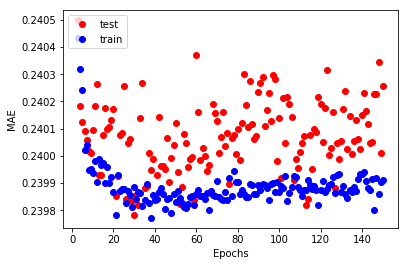

In [29]:
print("NMSE: ")
print(np.mean(nmse))

num_epochs = 150
val_mae_history = [np.mean([x['val_mae'][i] for x in histories]) for i in range(num_epochs)]
mae_history = [np.mean([x['mae'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(3, len(val_mae_history) + 1), val_mae_history[2:], 'ro')
plt.plot(range(3, len(mae_history) + 1), mae_history[2:], 'bo')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['test', 'train'], loc='upper left')
plt.show()

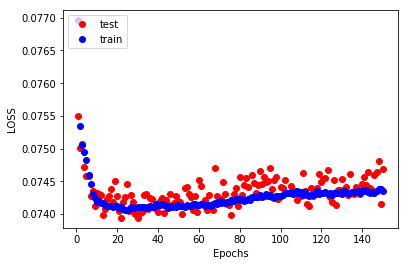

In [30]:
val_loss_history = [np.mean([x['val_loss'][i] for x in histories]) for i in range(num_epochs)]
loss_history = [np.mean([x['loss'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, 'ro')
plt.plot(range(1, len(loss_history) + 1), loss_history, 'bo')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['test', 'train'], loc='upper left')
plt.show()

In [31]:
model = get_model()

history = model.fit(inputs, targets, epochs=20, batch_size=1, verbose=1)
history.history['mae']
model.save("nn_sensor_reverse.h5")

Epoch 1/20
65341/65341 [==============================] - 64s 987us/step - loss: 0.0765 - mae: 0.2411
Epoch 2/20
65341/65341 [==============================] - 64s 979us/step - loss: 0.0753 - mae: 0.2403
Epoch 3/20
65341/65341 [==============================] - 61s 933us/step - loss: 0.0748 - mae: 0.2402
Epoch 4/20
65341/65341 [==============================] - 64s 984us/step - loss: 0.0745 - mae: 0.2401
Epoch 5/20
65341/65341 [==============================] - 92s 1ms/step - loss: 0.0744 - mae: 0.2398
Epoch 6/20
65341/65341 [==============================] - 91s 1ms/step - loss: 0.0742 - mae: 0.2399: 3s - lo - ETA: 0s - loss: 0.0742 - 
Epoch 7/20
65341/65341 [==============================] - 71s 1ms/step - loss: 0.0741 - mae: 0.2398
Epoch 8/20
65341/65341 [==============================] - 63s 959us/step - loss: 0.0741 - mae: 0.2397
Epoch 9/20
65341/65341 [==============================] - 72s 1ms/step - loss: 0.0742 - mae: 0.2397: 0s - lo
Epoch 10/20
65341/65341 [===================